<img src = "https://images2.imgbox.com/a5/72/7ZbDUHlf_o.jpg" width="200">



# Turma #867 - Projeto Machine Learning I - Equipe 03
---


## Modelo Random Forest

In [1]:
# importando bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

np.random.seed(4)

### Importação dos Dados

In [2]:
df_credit_train = pd.read_csv('dados/application_train.csv')

### Informações Sobre o Dataset

In [3]:
# primeiras 5 observações
df_credit_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


In [4]:
# últimas 5 observações
df_credit_train.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
246003,242114,0,Cash loans,F,N,Y,1,270000.0,1172470.5,34411.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
246004,452374,0,Cash loans,F,N,Y,0,180000.0,654498.0,27859.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
246005,276545,1,Revolving loans,M,N,N,1,112500.0,270000.0,13500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
246006,236776,1,Cash loans,M,Y,N,3,202500.0,204858.0,17653.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
246007,454197,0,Cash loans,F,N,Y,2,81000.0,547344.0,23139.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0


In [5]:
# o dataset possui 122 variáveis e 246008 observações
df_credit_train.shape

(246008, 122)

É perceptível o desbalanceamento das classes, o que poderá influenciar o resultado final. No entanto, será aplicada a técnica de sobreamostragem minoritária sintética SMOTE, de modo a equilibrar o conjunto de dados.

- 0: O cliente não teve dificuldades de pagamento
- 1: O cliente teve dificuldades de pagamento

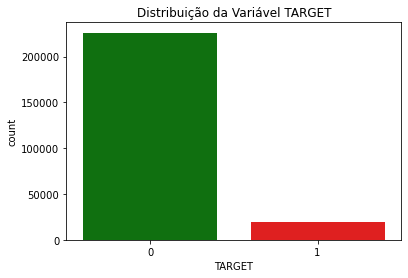

In [6]:
plt.title('Distribuição da Variável TARGET')
sns.countplot(x = df_credit_train.TARGET, palette = ['green', 'red']);

In [7]:
# separação do dataset em variáveis numéricas e categóricas
var_num = df_credit_train.select_dtypes(include=np.number).columns.tolist()
var_cat = df_credit_train.select_dtypes('object').columns.tolist()

In [8]:
# medidas resumo das variáveis quantitativas
df_credit_train[var_num].describe(percentiles = [.25, .5, .75, .95, .99])

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,246008.000000,246008.000000,246008.000000,2.460080e+05,2.460080e+05,245998.000000,2.457820e+05,246008.000000,246008.000000,246008.000000,...,246008.000000,246008.000000,246008.000000,246008.000000,212836.000000,212836.000000,212836.000000,212836.000000,212836.000000,212836.000000
mean,278280.072908,0.081176,0.415527,1.689122e+05,5.996283e+05,27129.162648,5.389289e+05,0.020882,-16042.794393,63963.755699,...,0.007975,0.000589,0.000508,0.000289,0.006291,0.006944,0.034487,0.267403,0.264109,1.900040
std,102790.909988,0.273106,0.719922,2.603818e+05,4.030672e+05,14504.965232,3.699738e+05,0.013852,4365.973763,141400.318322,...,0.088948,0.024271,0.022536,0.016986,0.083236,0.109538,0.204179,0.916640,0.611269,1.868217
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189165.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16561.125000,2.385000e+05,0.010006,-19691.000000,-2758.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278392.500000,0.000000,0.000000,1.485000e+05,5.147775e+05,24930.000000,4.500000e+05,0.018850,-15763.000000,-1215.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367272.250000,0.000000,1.000000,2.025000e+05,8.086500e+05,34599.375000,6.795000e+05,0.028663,-12418.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
95%,438466.650000,1.000000,2.000000,3.375000e+05,1.350000e+06,53329.500000,1.305000e+06,0.046220,-9413.000000,365243.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,6.000000
99%,452695.860000,1.000000,3.000000,4.725000e+05,1.870677e+06,69962.175000,1.800000e+06,0.072508,-8264.000000,365243.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,8.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,19.000000,23.000000


In [9]:
# número de classes únicas em cada variável categórica
df_credit_train[var_cat].nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Seleção de Features

Para aplicação do modelo foram selecionadas três variáveis que apresentaram menor correlação com a variável target, sendo elas: `EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3`, em que cada uma representa o score normalizado a partir de uma fonte de dados externa. 

E, posteriormente, as duas variáveis que apresentaram a maior correlação positiva, sendo elas: `DAYS_BIRTH` e `REGION_RATING_CLIENT_W_CITY`, referindo-se a idade do cliente em dias no momento do pedido e a classificação da região com a qual o cliente vive, respectivamente.

In [10]:
# encontrando correlações com a variável Target
correlations = df_credit_train.corr()['TARGET'].sort_values(ascending=False)

print('Correlações Positivas:')
print(correlations.head(5))
print('\nCorrelações Negativas:')
print(correlations.tail(5))

Correlações Positivas:
TARGET                         1.000000
DAYS_BIRTH                     0.079414
REGION_RATING_CLIENT_W_CITY    0.061518
REGION_RATING_CLIENT           0.059170
DAYS_LAST_PHONE_CHANGE         0.054471
Name: TARGET, dtype: float64

Correlações Negativas:
FLOORSMAX_AVG   -0.043720
DAYS_EMPLOYED   -0.044862
EXT_SOURCE_1    -0.158619
EXT_SOURCE_2    -0.160978
EXT_SOURCE_3    -0.179246
Name: TARGET, dtype: float64


In [11]:
# seleção das variáveis que serão utilizadas
df = df_credit_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY']]

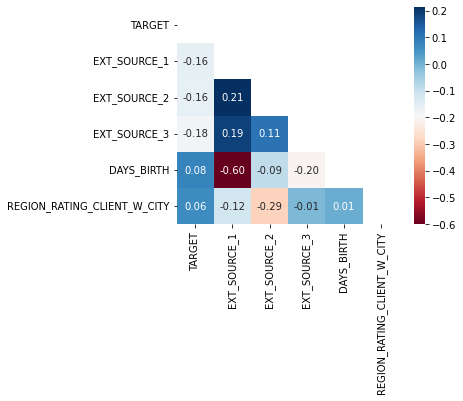

In [12]:
# matriz de correlação das variáveis selecionadas
sns.set_context(font_scale=1.9)
plt.figure(figsize=(5,4))
sns.heatmap(
    df.corr(), 
    annot=True, 
    fmt='.2f', 
    cmap='RdBu',
    mask=np.triu(
        np.ones_like(df.corr()) 
    ) 
);

In [13]:
# informações sobre os dados: nome das variáveis, tipo, valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       246008 non-null  int64  
 1   EXT_SOURCE_1                 107205 non-null  float64
 2   EXT_SOURCE_2                 245464 non-null  float64
 3   EXT_SOURCE_3                 197280 non-null  float64
 4   DAYS_BIRTH                   246008 non-null  int64  
 5   REGION_RATING_CLIENT_W_CITY  246008 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 11.3 MB


In [14]:
# medidas resumo das variáveis 
df.describe(percentiles = [.25, .5, .75, .95, .99])

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY
count,246008.000000,107205.000000,2.454640e+05,197280.000000,246008.000000,246008.000000
mean,0.081176,0.502277,5.143916e-01,0.510838,-16042.794393,2.031206
std,0.273106,0.211078,1.908912e-01,0.194880,4365.973763,0.502715
min,0.000000,0.014568,8.173617e-08,0.000527,-25229.000000,1.000000
25%,0.000000,0.334285,3.926530e-01,0.370650,-19691.000000,2.000000
50%,0.000000,0.505994,5.657089e-01,0.535276,-15763.000000,2.000000
75%,0.000000,0.675200,6.634999e-01,0.669057,-12418.000000,2.000000
95%,1.000000,0.832113,7.476510e-01,0.786267,-9413.000000,3.000000
99%,1.000000,0.889015,7.825231e-01,0.832785,-8264.000000,3.000000
max,1.000000,0.962693,8.549997e-01,0.896010,-7489.000000,3.000000


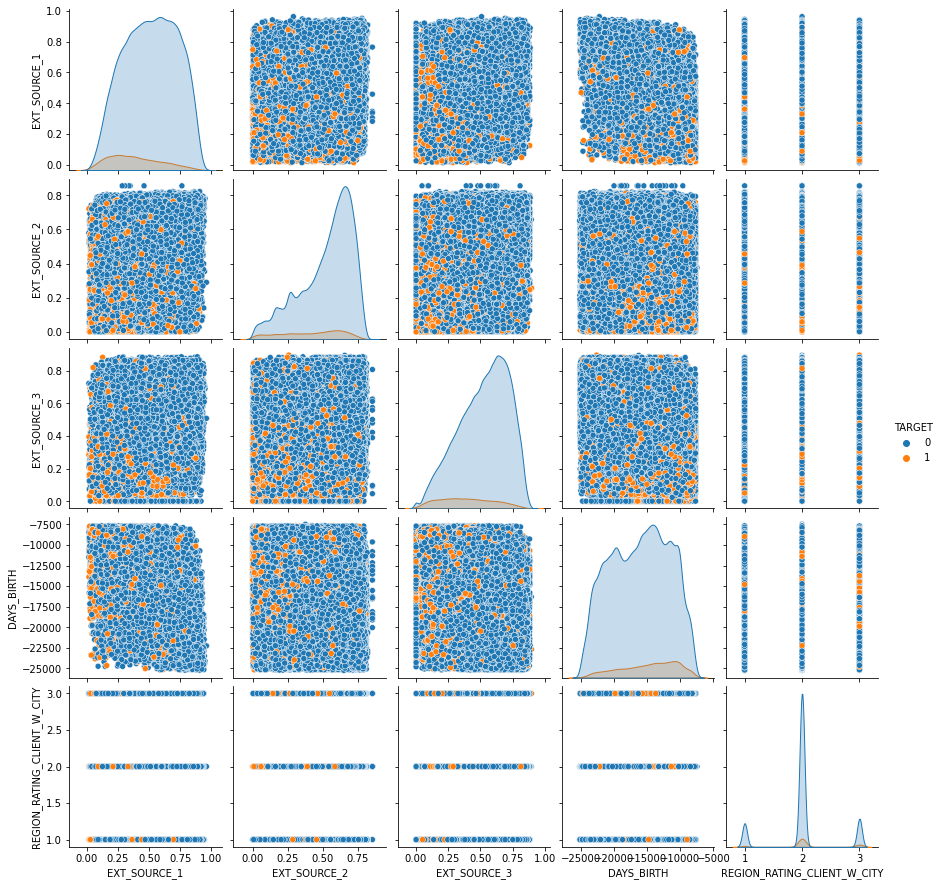

In [15]:
# visualização bivariada das variáveis selecionadas
sns.pairplot(df, hue='TARGET');

### Balanceamento das Classes

In [16]:
# preenchendo valores nan com 0
df = df.fillna(0)

# separando dados
X = df.drop(['TARGET'], axis=1).values
y = df[['TARGET']].values

# tratando o desbalanceamento das classes da variável target
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

### Aplicação do Modelo

In [17]:
# preenchendo valores nan com 0
df_credit_train = df_credit_train.fillna(0)

# separação dos dados
x_treino, x_teste, y_treino, y_teste = train_test_split(X_smote, y_smote, test_size=0.2, random_state=4)
    
modelo = RandomForestClassifier(n_estimators=100, random_state = 4)
modelo.fit(x_treino, y_treino)

y_teste_pred = modelo.predict_proba(x_teste)[:, 1]
y_pred = modelo.predict(x_teste)

### Métricas de Avalição do Modelo

In [18]:
print("Acurácia:", accuracy_score(y_teste, y_pred))
print("-------------")
print(classification_report(y_teste, y_pred))
print("------")
print("Area curva ROC:", roc_auc_score(y_teste, y_teste_pred))

Acurácia: 0.8467638471067068
-------------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85     45148
           1       0.86      0.82      0.84     45268

    accuracy                           0.85     90416
   macro avg       0.85      0.85      0.85     90416
weighted avg       0.85      0.85      0.85     90416

------
Area curva ROC: 0.9267913910644631


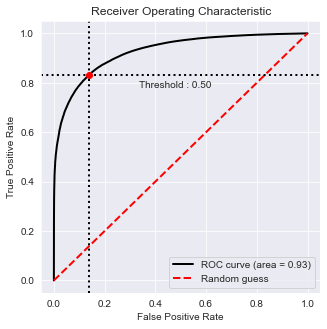

In [19]:
# plot curva ROC
bc = BinaryClassification(y_teste, y_teste_pred, labels=[0, 1])

plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

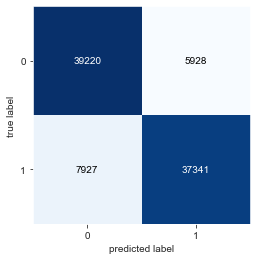

In [20]:
# matriz de confusão
cm = confusion_matrix(y_teste, y_pred)
plot_confusion_matrix(cm)
plt.show()

### Aplicação do Modelo no Dataset `application_test_student`

In [29]:
# importação dos dados
df_teste = pd.read_csv('dados/application_test_student.csv')

In [30]:
# seleção das variáveis que serão utilizadas
df_teste = df_teste[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY']]

In [31]:
# informações sobre os dados: tipo, valores nulos
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   61503 non-null  int64  
 1   EXT_SOURCE_1                 26928 non-null  float64
 2   EXT_SOURCE_2                 61387 non-null  float64
 3   EXT_SOURCE_3                 49266 non-null  float64
 4   DAYS_BIRTH                   61503 non-null  int64  
 5   REGION_RATING_CLIENT_W_CITY  61503 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 2.8 MB


In [32]:
# preenchendo valores nan com 0
df_teste = df_teste.fillna(0)

# prevendo target 
y_pred2 = modelo.predict(df_teste[['EXT_SOURCE_1','EXT_SOURCE_2',
                                   'EXT_SOURCE_3','DAYS_BIRTH',
                                   'REGION_RATING_CLIENT_W_CITY']].values)
# probilidade da target
proba = modelo.predict_proba(df_teste[['EXT_SOURCE_1','EXT_SOURCE_2',
                                       'EXT_SOURCE_3','DAYS_BIRTH',
                                       'REGION_RATING_CLIENT_W_CITY']].values)

In [33]:
# juntando target com dataset df_teste
temp = pd.DataFrame(data = y_pred2, columns = ['TARGET'], index = df_teste.index.copy())
df_teste = pd.merge(df_teste, temp.TARGET, how = 'left', left_index = True, right_index = True)

# juntando probabilidades com dataset df_teste
temp = pd.DataFrame(data = proba, columns = ['PRED_0', 'PRED_1'], index = df_teste.index.copy())
df_teste = pd.merge(df_teste, temp, how = 'left', left_index = True, right_index = True)

In [34]:
df_teste

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,TARGET,PRED_0,PRED_1
0,149741,0.484936,0.182710,0.145543,-21774,3,1,0.27,0.73
1,363290,0.624574,0.669053,0.680139,-18499,1,0,0.94,0.06
2,436006,0.000000,0.454279,0.173527,-18084,2,1,0.27,0.73
3,377703,0.000000,0.688145,0.440058,-12319,2,0,0.78,0.22
4,188624,0.000000,0.426409,0.081726,-10151,2,1,0.14,0.86
...,...,...,...,...,...,...,...,...,...
61498,102817,0.000000,0.641852,0.000000,-17817,3,0,0.76,0.24
61499,343961,0.000000,0.297216,0.492060,-22836,3,0,0.83,0.17
61500,427828,0.000000,0.596971,0.654529,-20014,3,0,0.71,0.29
61501,405956,0.000000,0.296855,0.701696,-8201,2,0,0.81,0.19


In [35]:
# selecionando maior valor de probabilidade
df_teste['PRED'] = np.where(df_teste['PRED_0'] > df_teste['PRED_1'], df_teste['PRED_0'], df_teste['PRED_1'])
df_teste.drop(['PRED_0','PRED_1'], inplace=True, axis=1)

In [36]:
df_teste

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,TARGET,PRED
0,149741,0.484936,0.182710,0.145543,-21774,3,1,0.73
1,363290,0.624574,0.669053,0.680139,-18499,1,0,0.94
2,436006,0.000000,0.454279,0.173527,-18084,2,1,0.73
3,377703,0.000000,0.688145,0.440058,-12319,2,0,0.78
4,188624,0.000000,0.426409,0.081726,-10151,2,1,0.86
...,...,...,...,...,...,...,...,...
61498,102817,0.000000,0.641852,0.000000,-17817,3,0,0.76
61499,343961,0.000000,0.297216,0.492060,-22836,3,0,0.83
61500,427828,0.000000,0.596971,0.654529,-20014,3,0,0.71
61501,405956,0.000000,0.296855,0.701696,-8201,2,0,0.81


In [38]:
# salvando previsões em csv
df_save = df_teste[['SK_ID_CURR','PRED']]
df_save.to_csv('dados/previsao-random-forest.csv', index=False)

---